# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [1]:
%load_ext nb_black
# makes Python code more structured automatically

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To tune model, get different metric scores, and split data

from sklearn import metrics

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

<IPython.core.display.Javascript object>

## Loading Data

In [2]:
data = pd.read_csv("Train.csv")

<IPython.core.display.Javascript object>

In [3]:
data_test = pd.read_csv("Test.csv")

<IPython.core.display.Javascript object>

In [4]:
df = data.copy()

<IPython.core.display.Javascript object>

In [5]:
df_test = data_test.copy()

<IPython.core.display.Javascript object>

In [6]:
df.shape

(20000, 41)

<IPython.core.display.Javascript object>

The train data set has 20000 rows and 41 columns.

In [7]:
df_test.shape

(5000, 41)

<IPython.core.display.Javascript object>

The test data set has 5000 rows and 41 columns.

In [8]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


<IPython.core.display.Javascript object>

In [9]:
df.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


<IPython.core.display.Javascript object>

In [10]:
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


<IPython.core.display.Javascript object>

In [11]:
df_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


<IPython.core.display.Javascript object>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

<IPython.core.display.Javascript object>

There are 41 attributes in the dataset which of all are float except the target variable which is int.

In [13]:
# Checking if there are duplicate values in the train dataset at row level
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

There are no row level duplicates in the train data set.

In [14]:
# Checking if there are duplicate values in the test dataset at row level
df_test.duplicated().sum()

0

<IPython.core.display.Javascript object>

There are no row level duplicates in test data set too.

In [15]:
# Statistical description of the variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


<IPython.core.display.Javascript object>

From the counts, looks like there are missing values in 2 columns V1 and V2. 

The other statistical description shows values of minimum and maximum along with some quartile ranges. All the features has a minimum values in negative and maximum in positives. There seems to be range of negative 20 till positive 20 in all features.

Many features have huge variance between 3rd quartile and max values; as well as 25% quartile and min values. So there are many outliers in the data; need to find out more if they are valid. 

In [16]:
df["Target"].value_counts()

0    18890
1     1110
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

Train dataset has 1110 failures and 18890 no failures.

In [17]:
df_test["Target"].value_counts()

0    4718
1     282
Name: Target, dtype: int64

<IPython.core.display.Javascript object>

Test dataset has 282 failures and 4718 no failures.

In [18]:
# Checking for missing values in Train data set
df.isna().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

V1 and V2 columns have got some missing values, in Train data set.

In [19]:
df_test.isna().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

<IPython.core.display.Javascript object>

In Test data set as well, V1 and V2 columns have got some missing values.

## EDA

## Univariate Analysis

### Plotting histograms and boxplots for all the variables

In [20]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

### Plotting all the features at one go

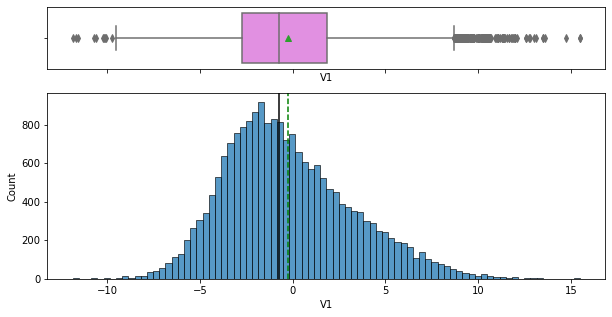

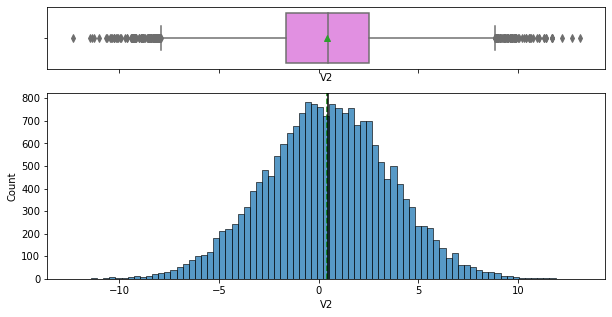

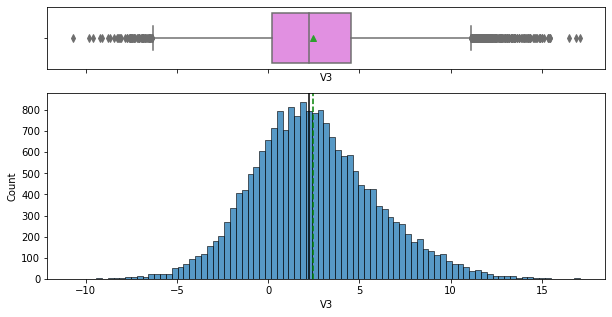

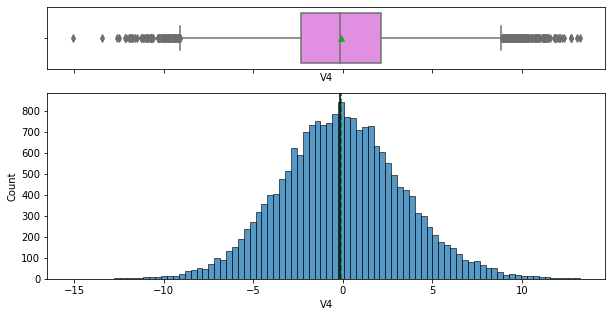

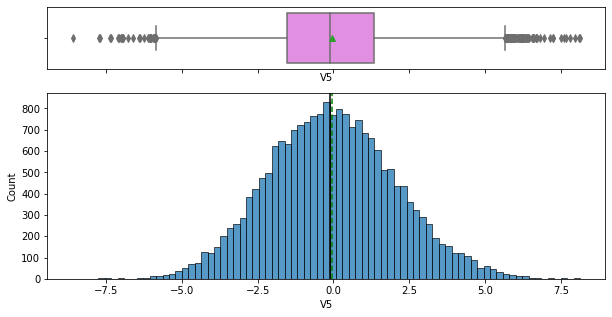

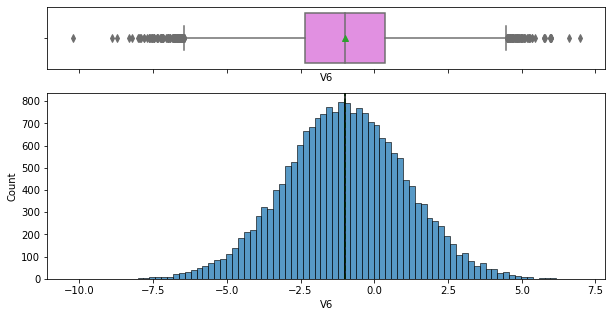

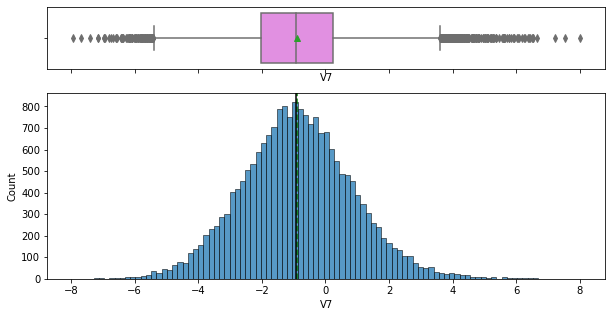

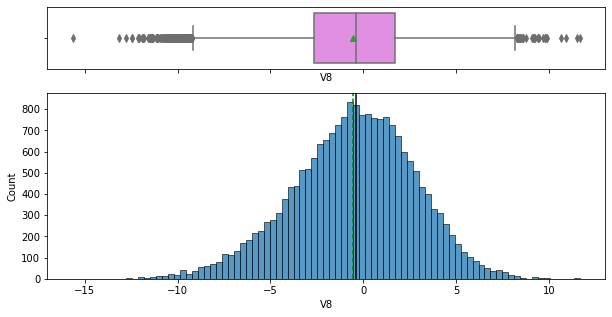

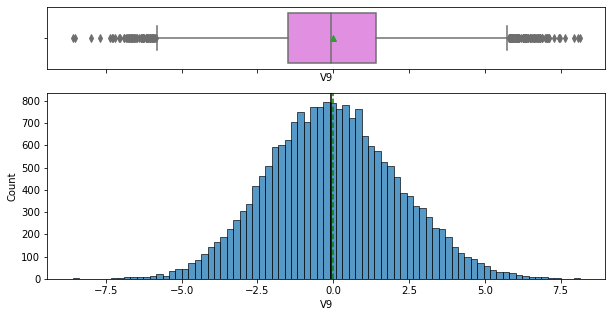

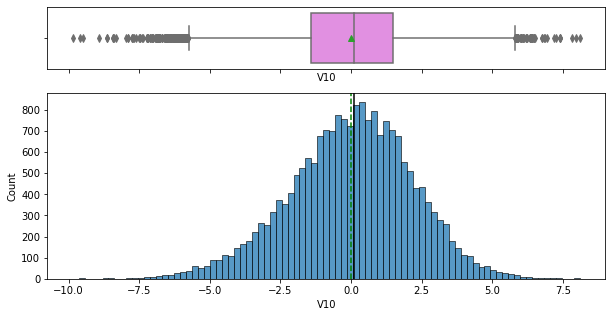

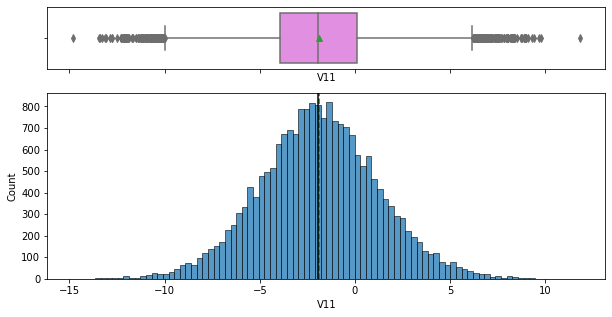

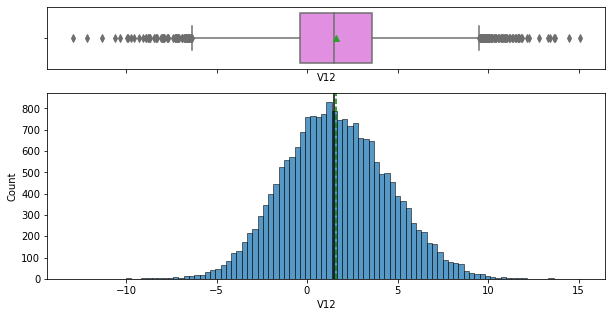

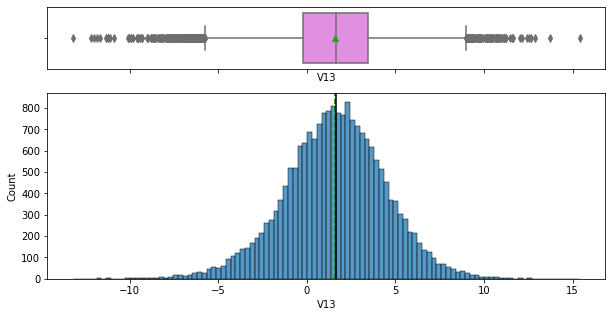

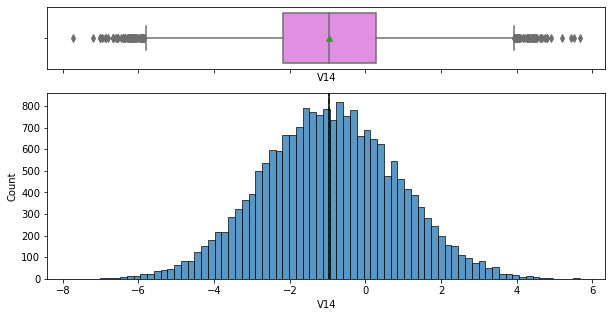

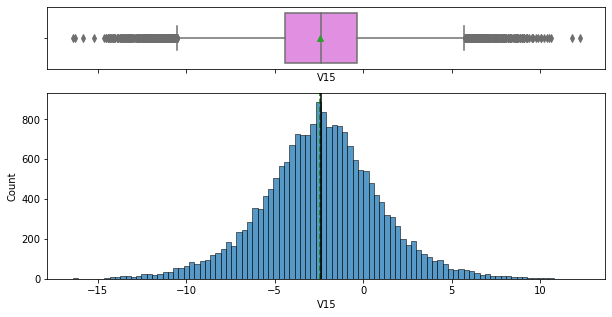

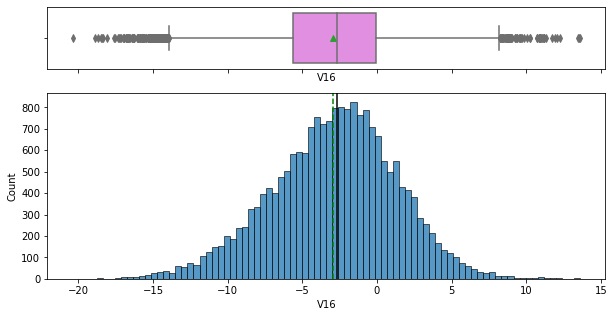

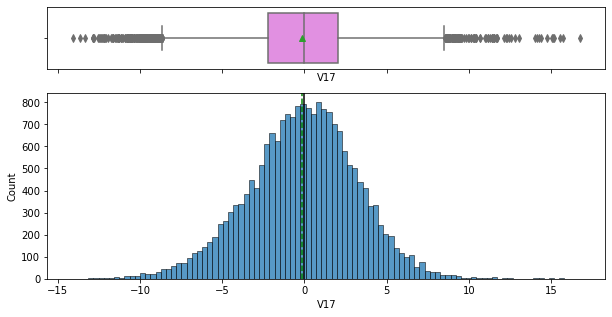

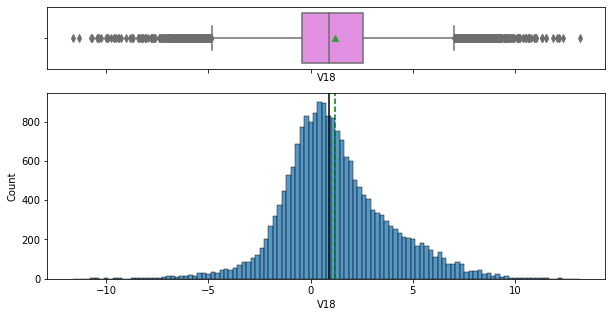

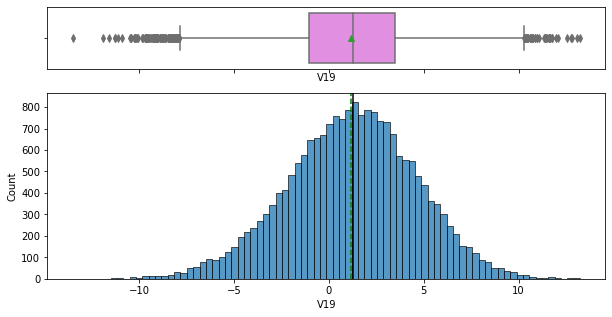

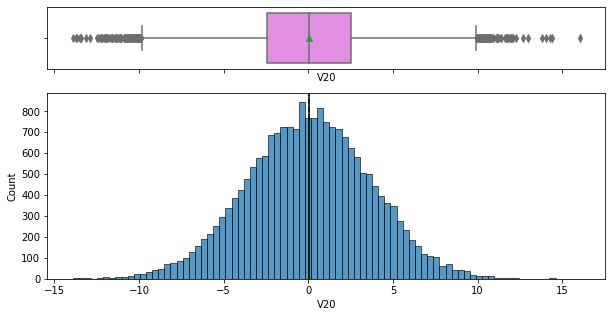

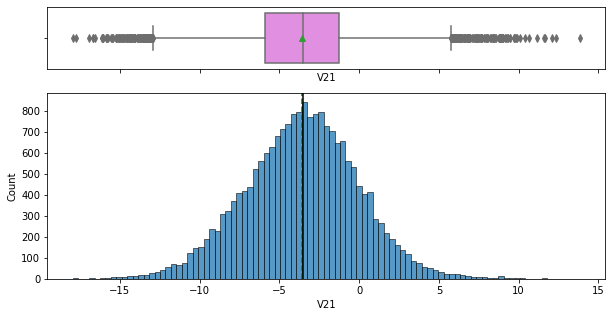

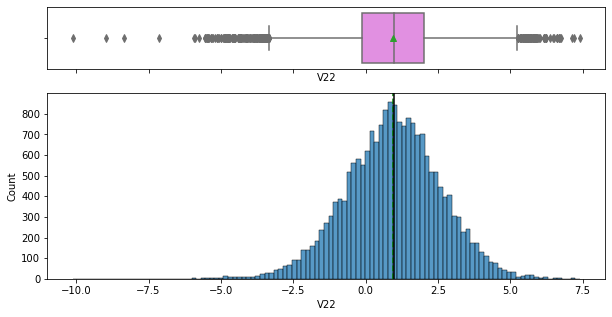

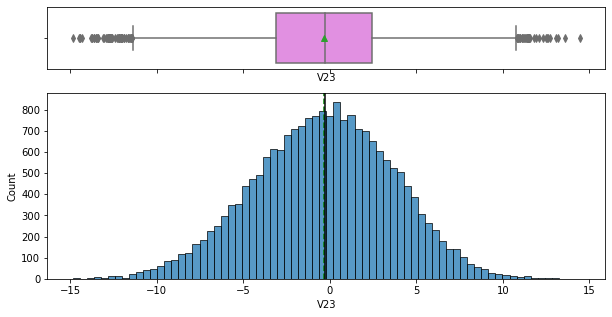

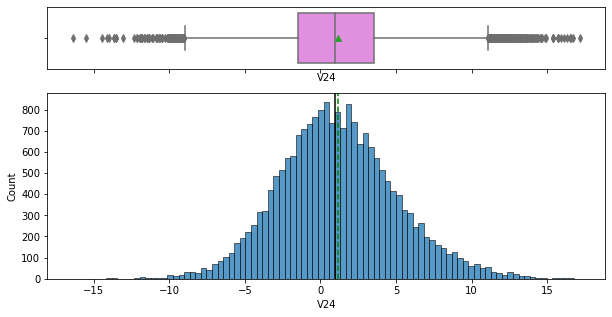

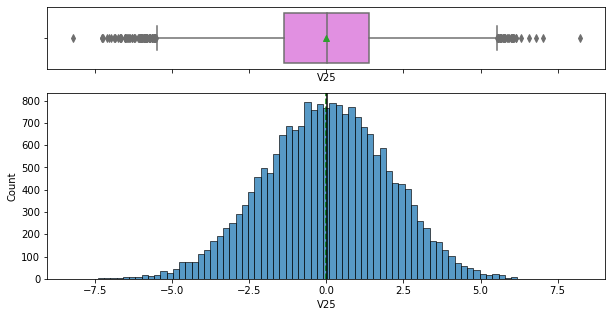

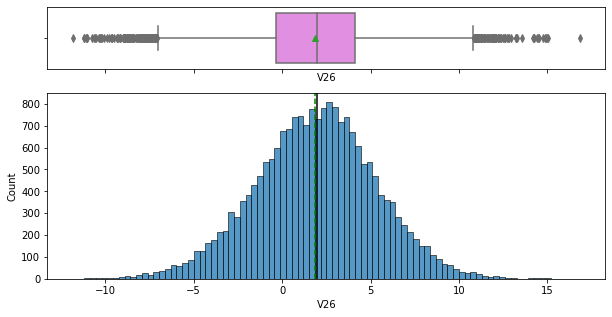

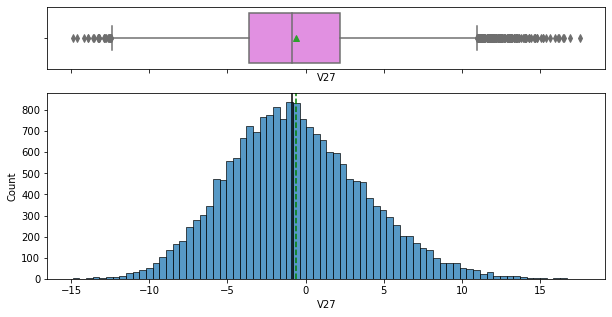

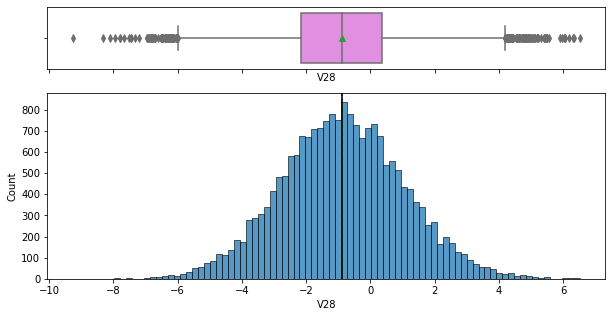

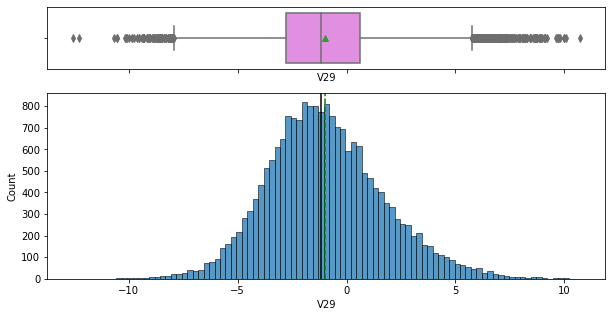

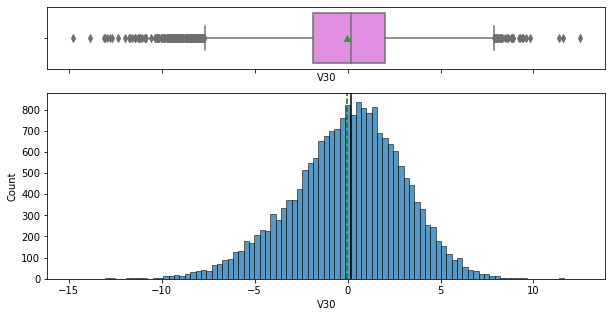

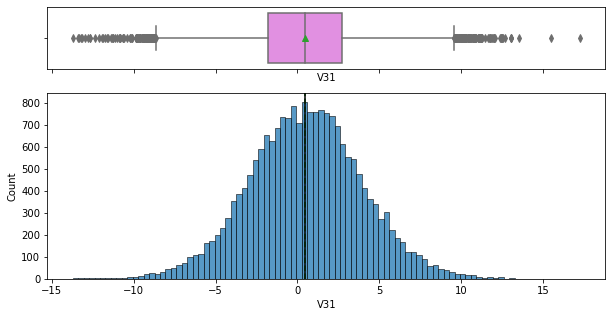

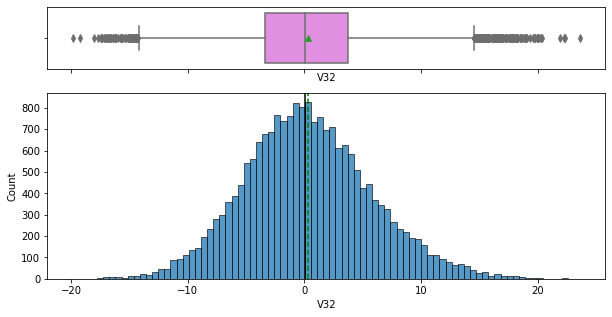

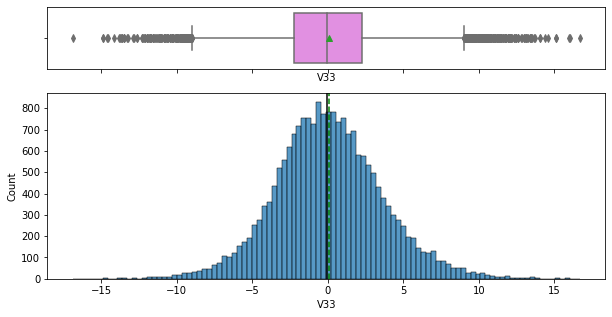

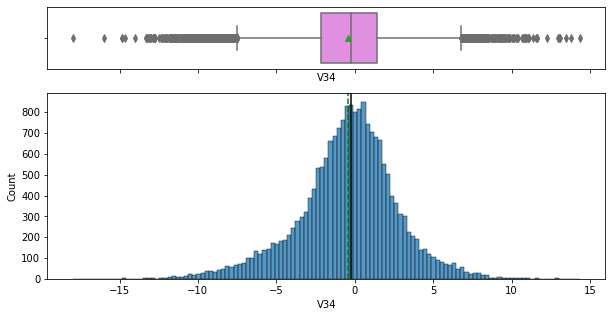

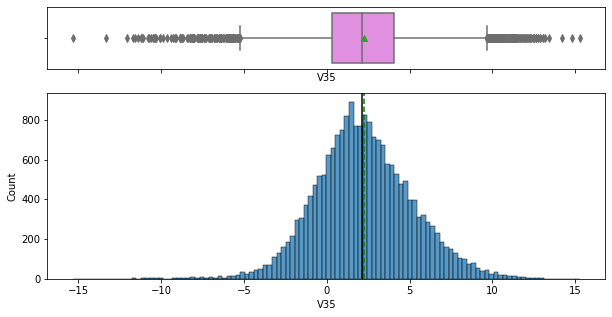

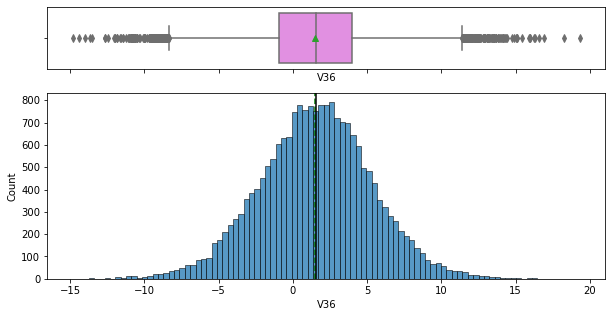

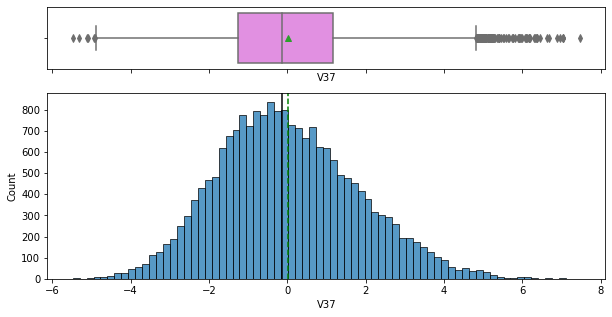

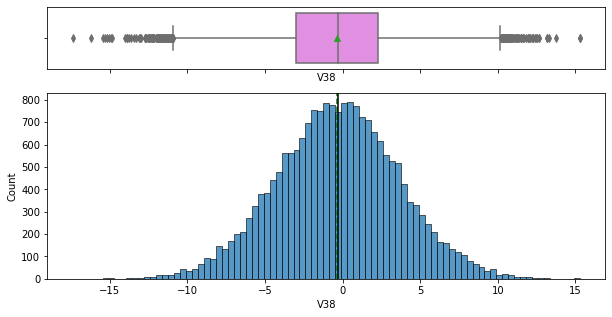

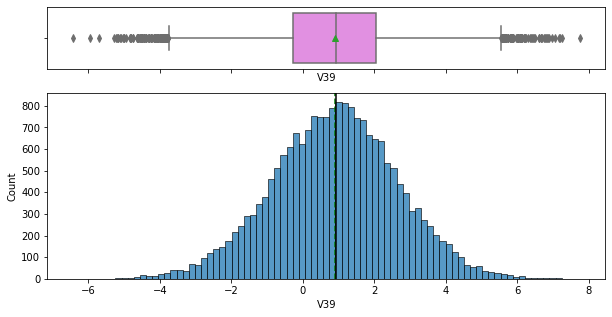

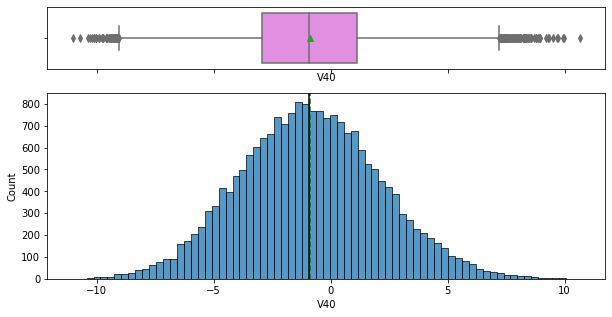

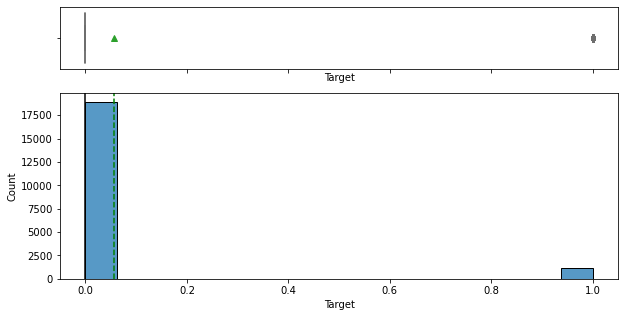

<IPython.core.display.Javascript object>

In [21]:
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(10, 5), kde=False, bins=None)

***Observations:***
Slight difference between Mean and Median for these below features:

* Right skewed:V1,V3,V18,V27,V29,V32,V37
* Left skweed: V8,V10,V16,V30,V34

V22 - median and median are almost same; however there are couple of outliers to the left.

All other features are having very much symmetrical (Bell curves).

## Bivariate and Multivariate analysis

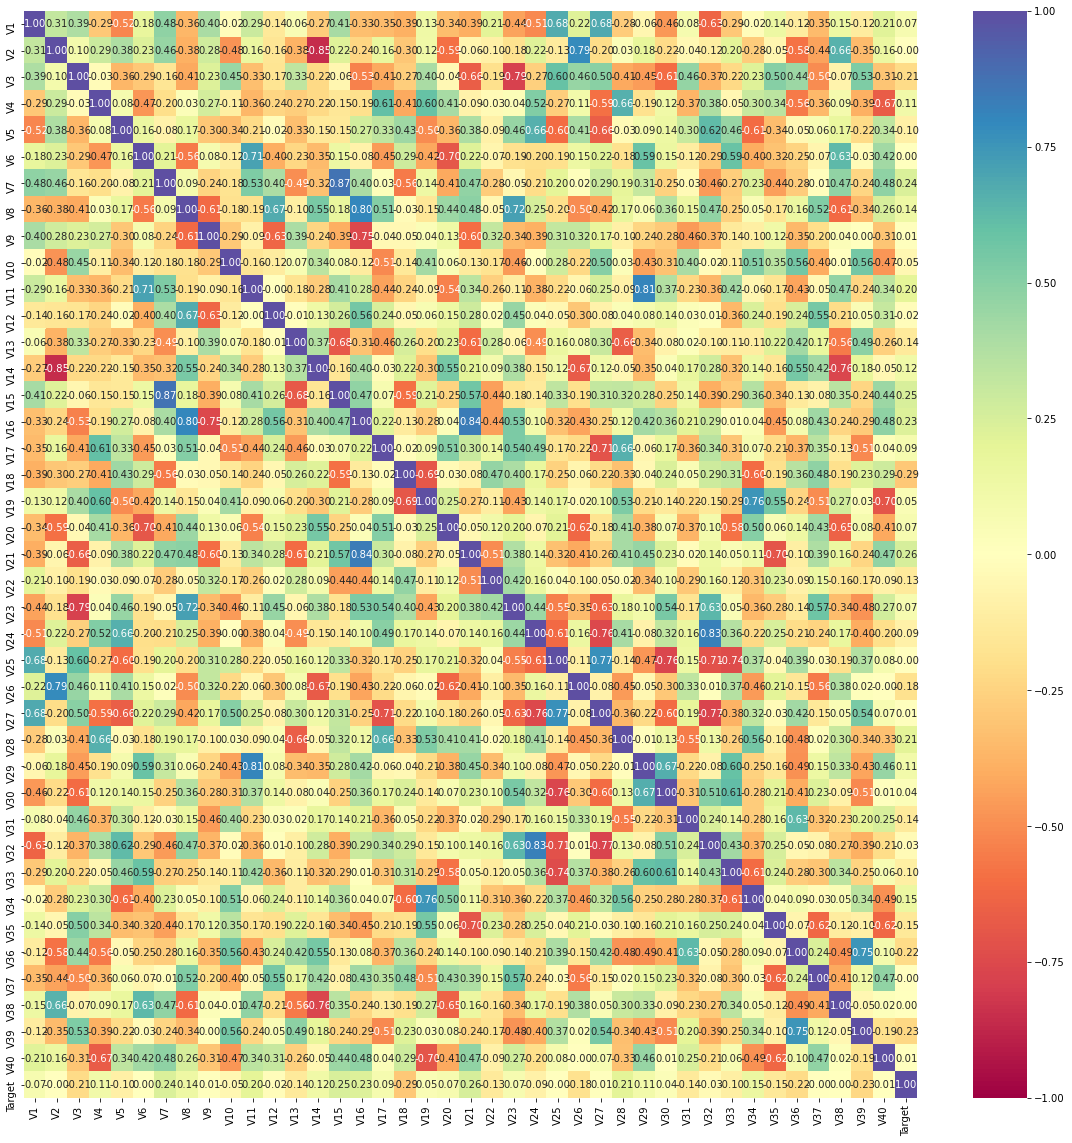

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

There are couple of variables having a correlation with each other; but not seeing very good correlation with the Target variable.

In [23]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

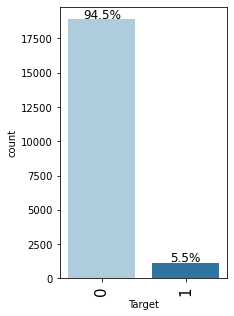

<IPython.core.display.Javascript object>

In [24]:
# labeled barplot on 'Target'
labeled_barplot(df, "Target", perc=True)

Training dataset has 94.5% non failures and 5.5% failures data.

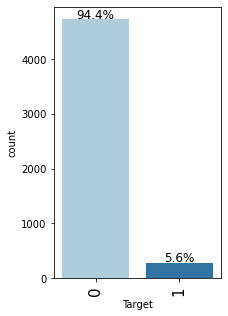

<IPython.core.display.Javascript object>

In [25]:
# labeled barplot on 'Target'
labeled_barplot(df_test, "Target", perc=True)

Similar to train, test data set also has 94.4% non failures and 5.6% failures in data.

In [26]:
# Finding average of values for each feature
df.mean()

V1       -0.272
V2        0.440
V3        2.485
V4       -0.083
V5       -0.054
V6       -0.995
V7       -0.879
V8       -0.548
V9       -0.017
V10      -0.013
V11      -1.895
V12       1.605
V13       1.580
V14      -0.951
V15      -2.415
V16      -2.925
V17      -0.134
V18       1.189
V19       1.182
V20       0.024
V21      -3.611
V22       0.952
V23      -0.366
V24       1.134
V25      -0.002
V26       1.874
V27      -0.612
V28      -0.883
V29      -0.986
V30      -0.016
V31       0.487
V32       0.304
V33       0.050
V34      -0.463
V35       2.230
V36       1.515
V37       0.011
V38      -0.344
V39       0.891
V40      -0.876
Target    0.056
dtype: float64

<IPython.core.display.Javascript object>

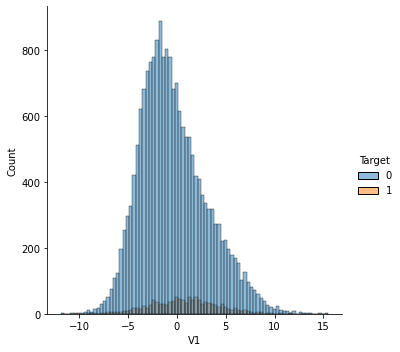

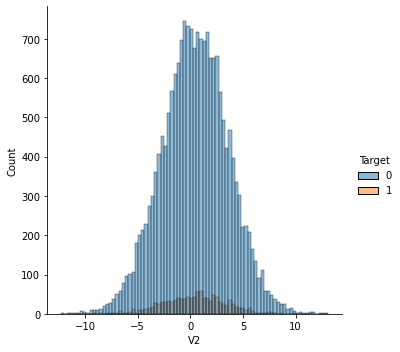

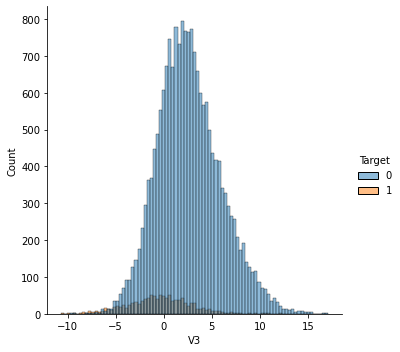

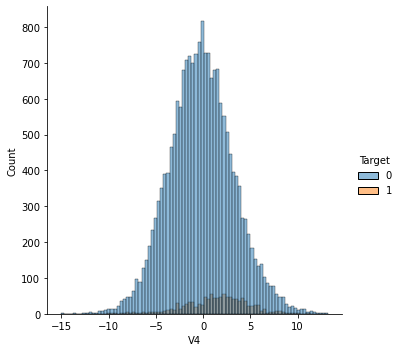

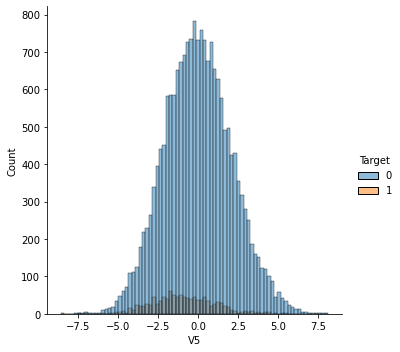

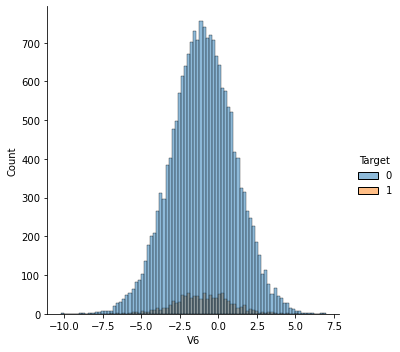

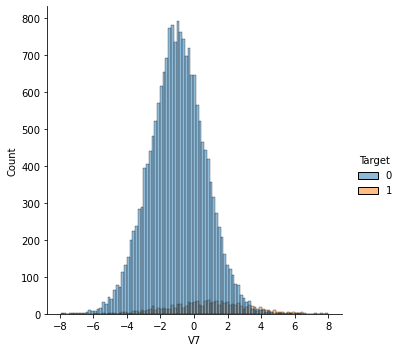

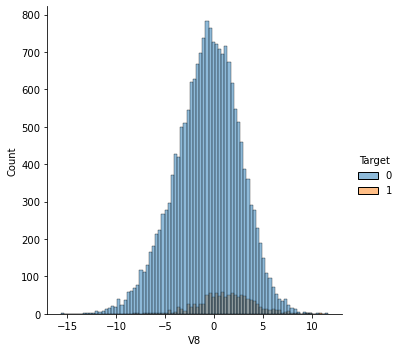

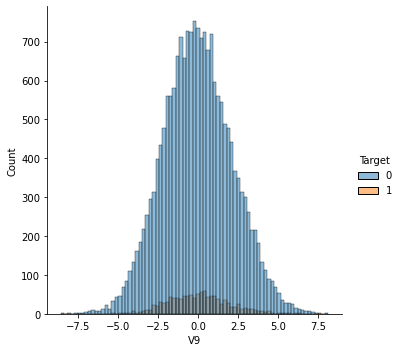

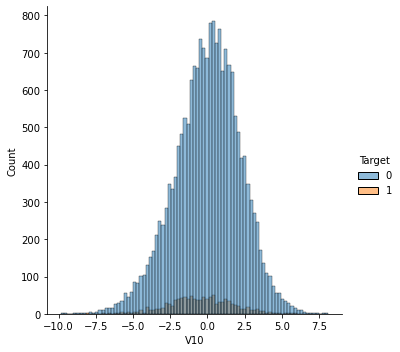

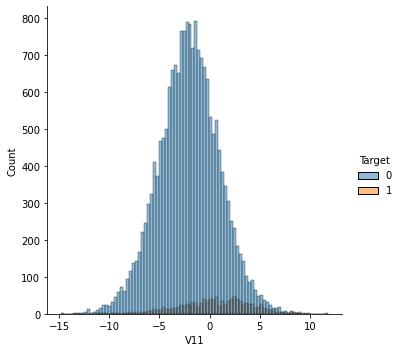

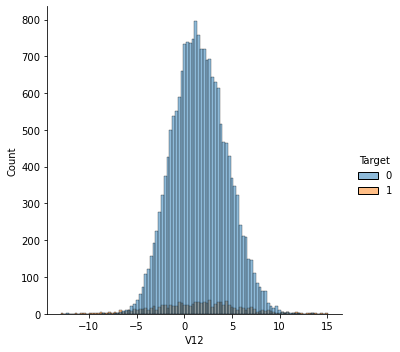

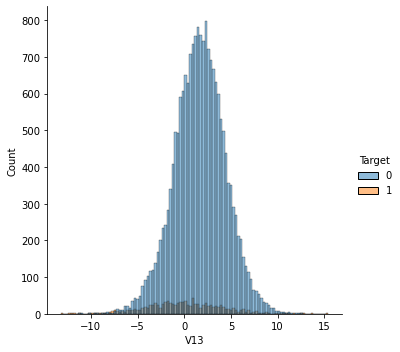

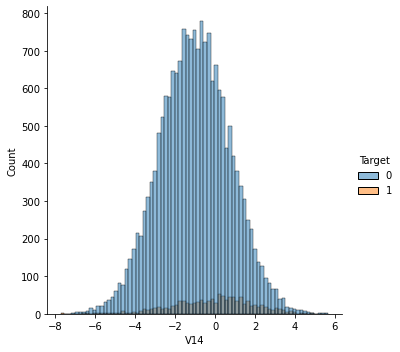

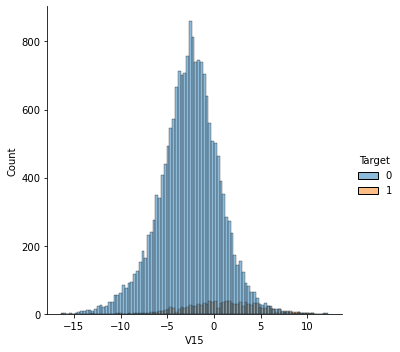

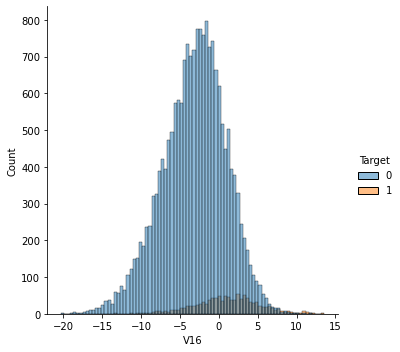

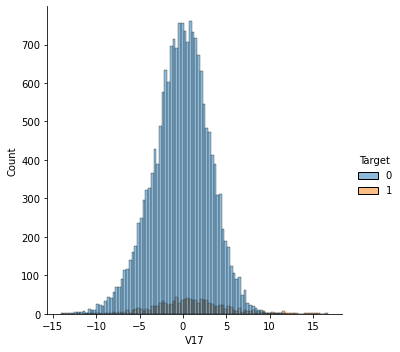

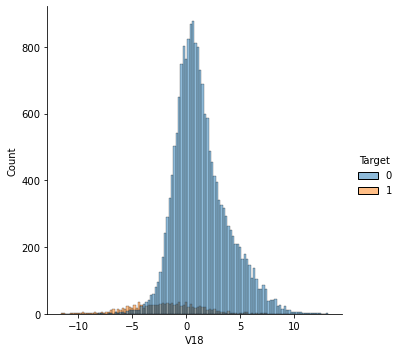

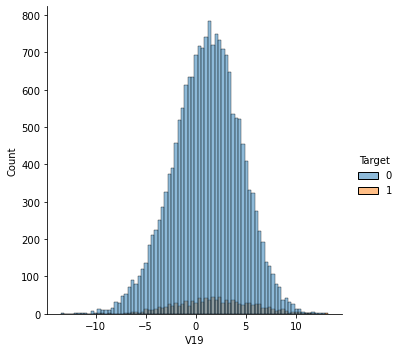

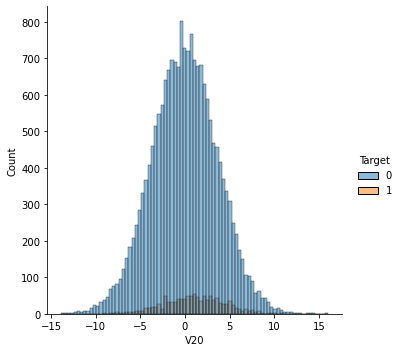

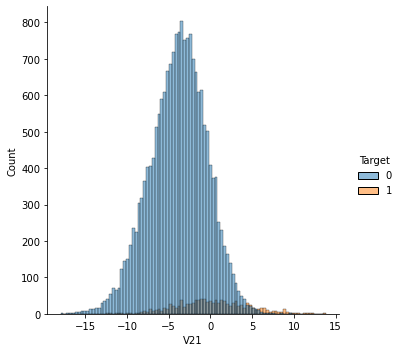

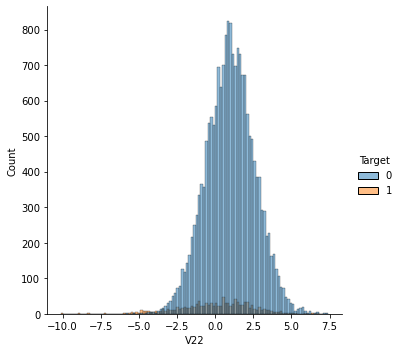

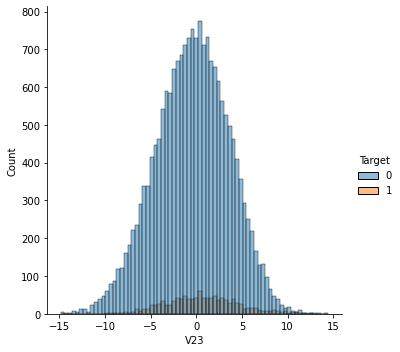

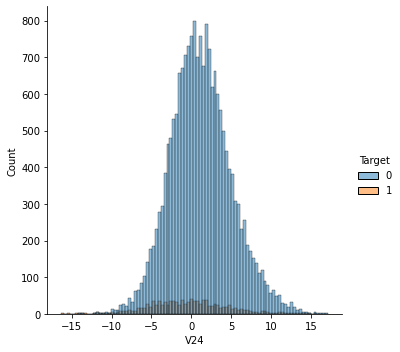

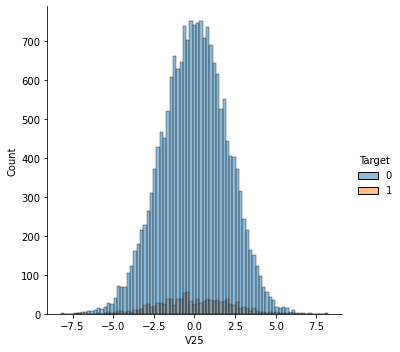

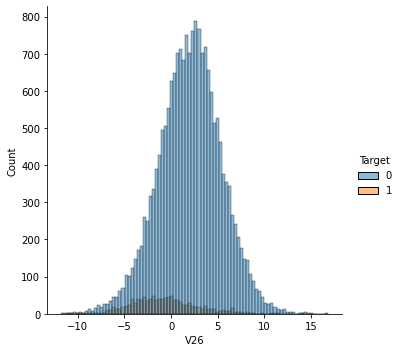

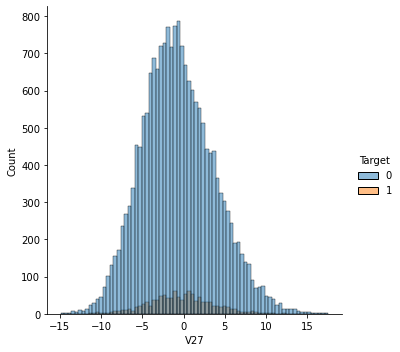

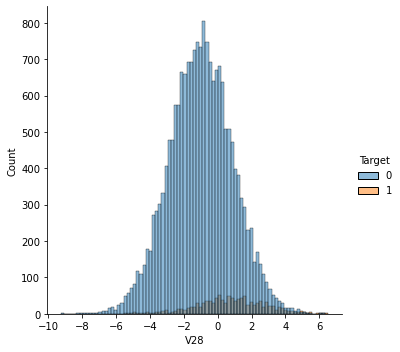

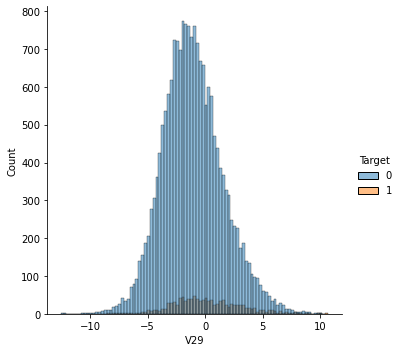

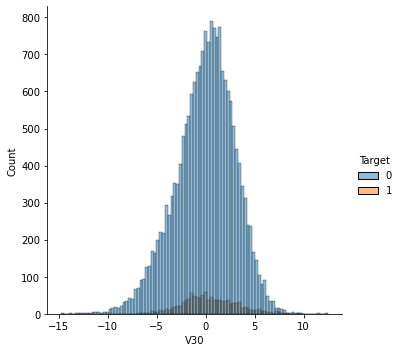

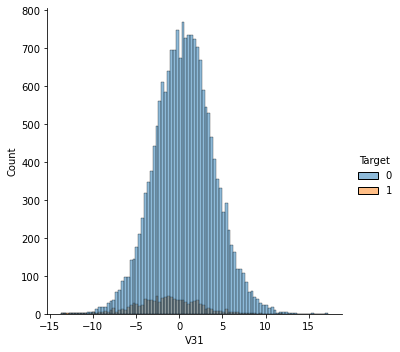

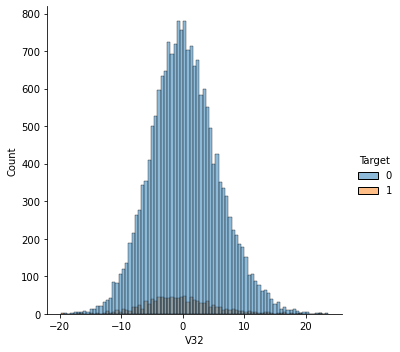

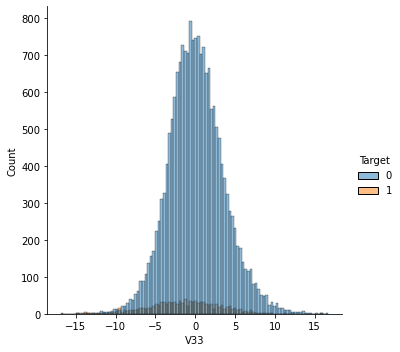

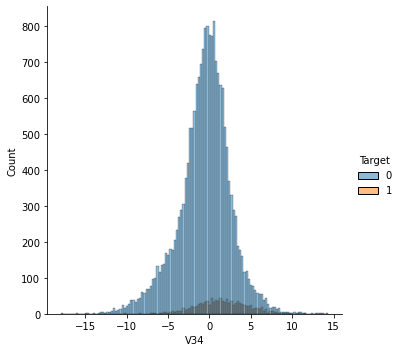

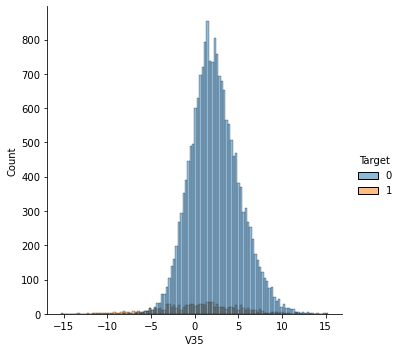

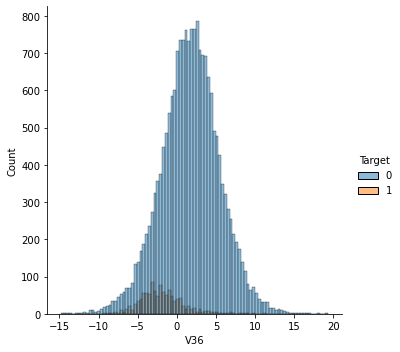

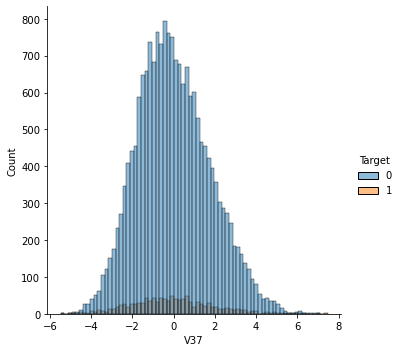

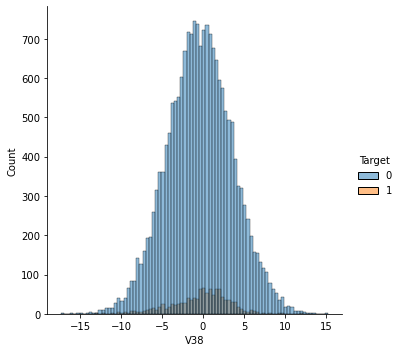

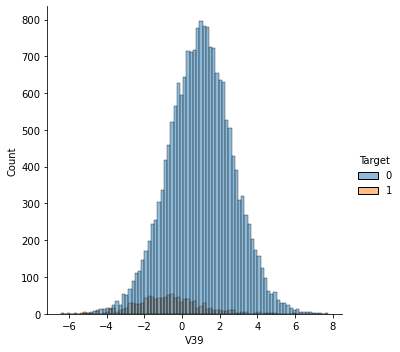

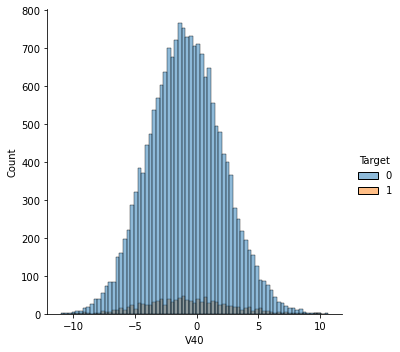

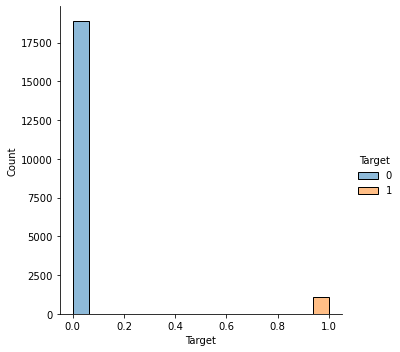

<IPython.core.display.Javascript object>

In [27]:
# Displot with a hue on Target variable
for feature in df.columns:
    sns.displot(df, x=feature, hue="Target")

**Observations:**
Almost all the features have Target values overlapped; so not able to make much hypothesis.

V3 - A little distinguishing values towards negative on this feauture, is yielding a Target of 1.

V7 - Slight Positive values on this feature is yielding Target of 1.

V16 - Slight positive values on this feature too, is yielding Target of 1.

V18 - A good visible distinguishing feature when Target is 0 vs 1; the V18 values are a little on the lower side when the Target value is 1. So this feature would have some imapct on the Target variable.

V21 - A good distinguishing feature when Target is 0 vs 1; the V21 values are a little towards positive side when the Target value is 1. So this feature would have some imapct on the Target variable.

***Outlier detection using Boxplots***

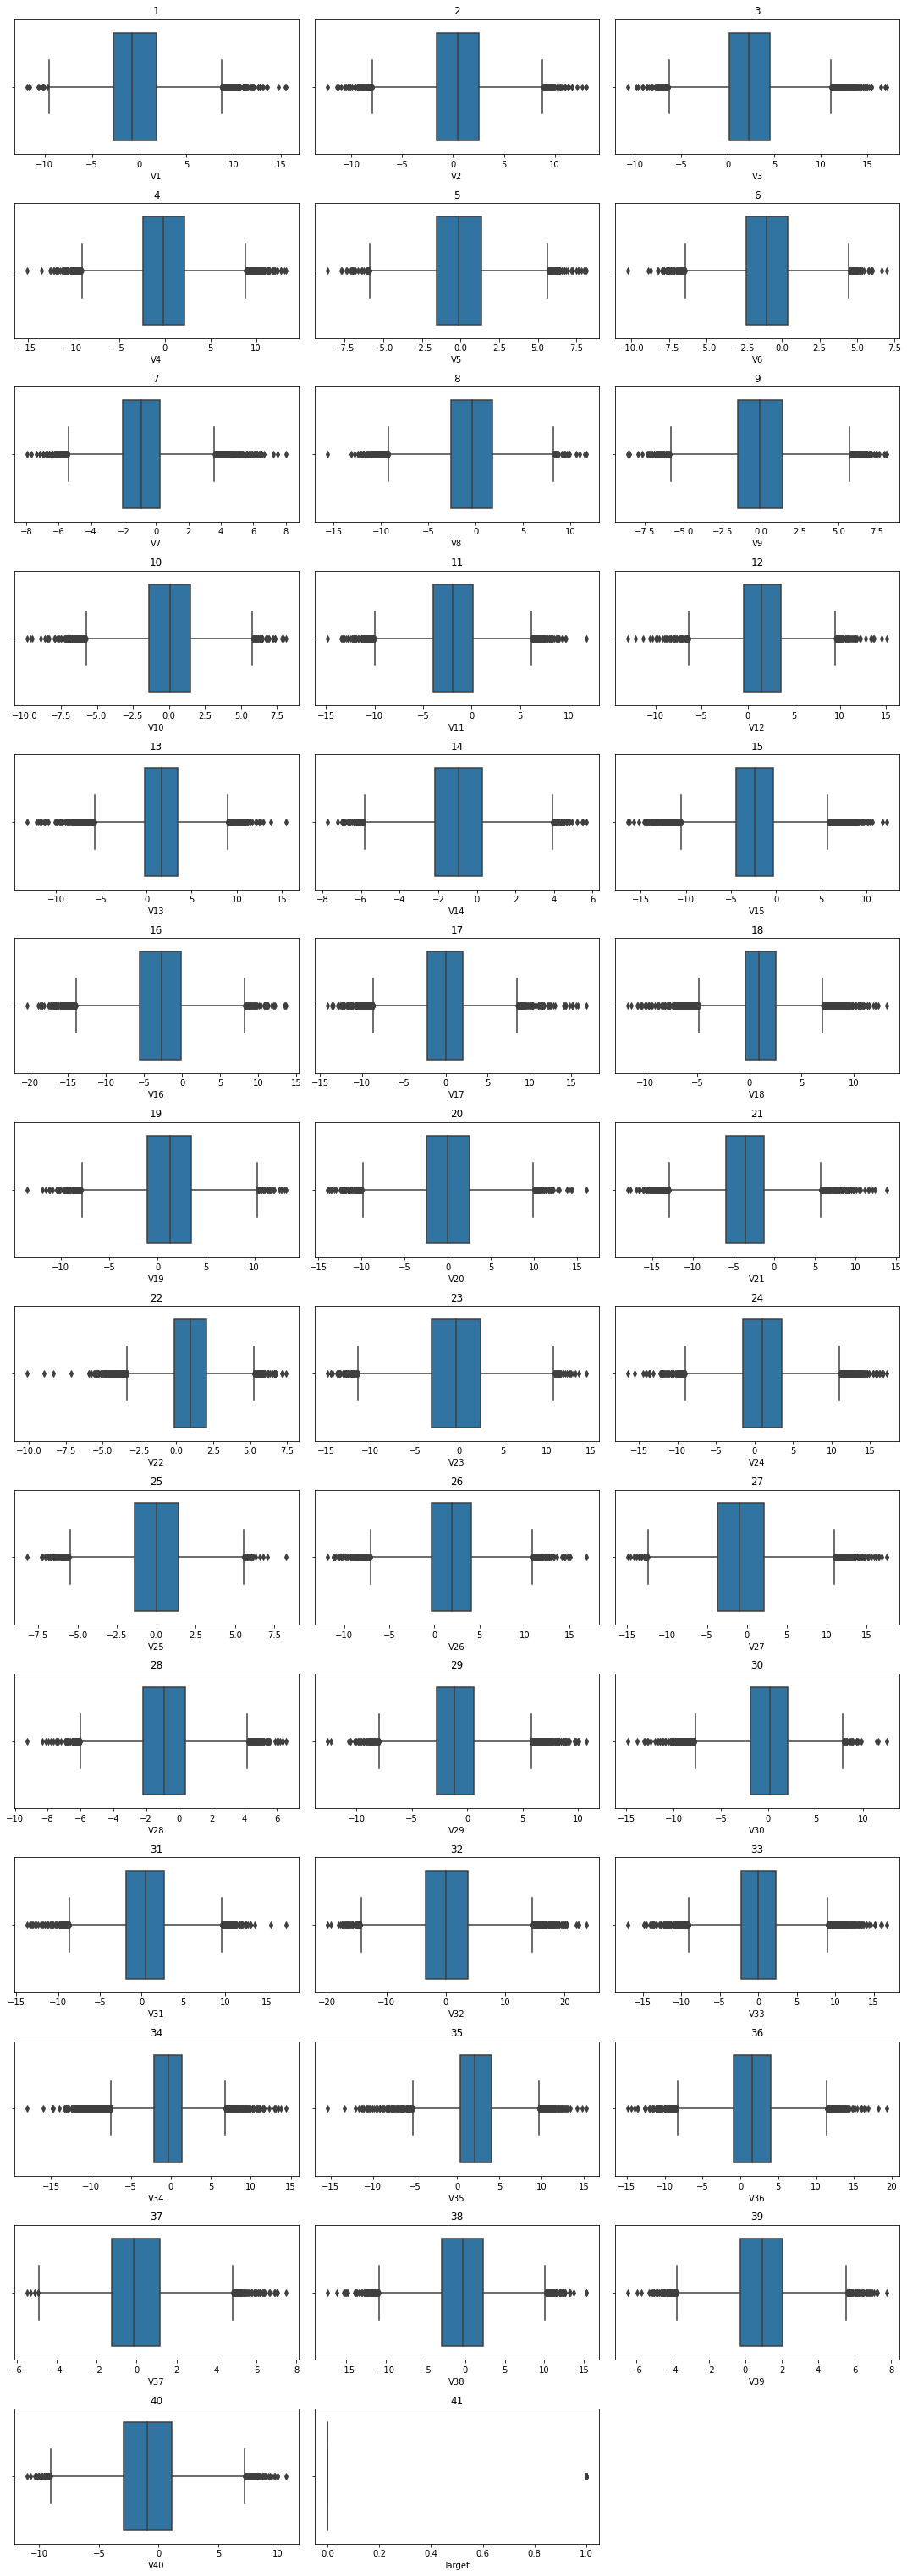

<IPython.core.display.Javascript object>

In [28]:
# Detecting outliers in the data using boxplot
cols_list = df.select_dtypes(include=np.number).columns.tolist()
# dropping yr_of_estab as it is a temporal variable
# cols_list.remove("yr_of_estab")
plt.figure(figsize=(15, 45))

# for i, variable in enumerate(cols_list):
for i in range(len(cols_list)):
    plt.subplot(15, 3, i + 1)
    sns.boxplot(data=df, x=cols_list[i])  # , kde=True)
    #    cols_list.plot(kind='box',subplots=False, ax=axis)
    plt.tight_layout()
    plt.title(i + 1)
plt.show()

There are multiple outliers for each of the features, but not having enough detail if these are valid values or real outliers. In real scenario, we could check with Business about these outliers.

## Data Pre-processing

In [29]:
# Dividing train data into X and y
X = df.drop(["Target"], axis=1)
y = df["Target"]

# Dividing test data into X_test and y_test
X_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

<IPython.core.display.Javascript object>

In [30]:
# Splitting data into training and validation set:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


<IPython.core.display.Javascript object>

The train data set is divided into 75-25% to train and validation data. Test data set is untouched and is retained as is.

In [31]:
# Let's impute the missing values in columns V1 and V2
imputer = SimpleImputer(strategy="median")
cols_to_impute = ["V1", "V2"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imputer.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imputer.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imputer.transform(X_test[cols_to_impute])

<IPython.core.display.Javascript object>

Missing value treatment is done on train, validation and test data sets separately to avoid data leakage. If we did before the split of train vs Validation, the impute process would be impacted by the whole dataset which would later be split to Validation and this might lead to data leakage.

In [32]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)

print(X_val.isna().sum())
print("-" * 30)

print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

<IPython.core.display.Javascript object>

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

### Which metric to optimize?

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [33]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [34]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [35]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

<IPython.core.display.Javascript object>

### Model Building with original data

Model building with original data and default parameters

In [36]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistict Regression", LogisticRegression(random_state=1)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Cross-Validation Cost:

Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118
dtree: 0.6982829521679532
Logistict Regression: 0.4927566553639709

Validation Performance:

Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
dtree: 0.7050359712230215
Logistict Regression: 0.48201438848920863


<IPython.core.display.Javascript object>

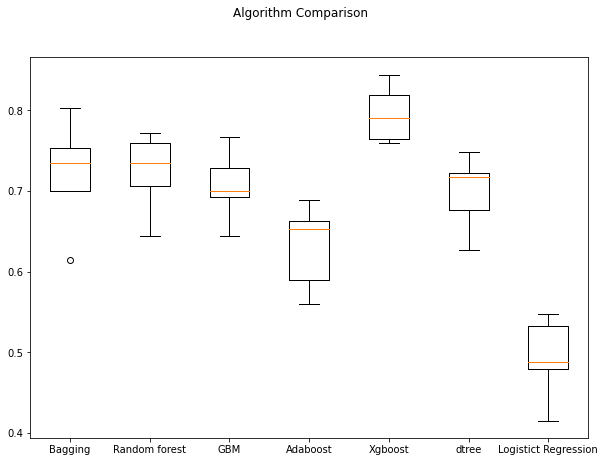

<IPython.core.display.Javascript object>

In [37]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

XGBoost is giving the highest average Cross Validation Recall score of 0.79 and a good validation score. Bagging and Random Forest are very close by with 0.72 Cross Validation recall score with the next best validation score.

### Model Building with Oversampled data


In [38]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



<IPython.core.display.Javascript object>

In [39]:
models1 = []  # Empty list to store all the models created with over sampling

# Appending models into the list
models1.append(("Bagging with Over Sampling", BaggingClassifier(random_state=1)))
models1.append(
    ("Random forest with Over Sampling", RandomForestClassifier(random_state=1))
)
models1.append(("GBM with Over Sampling", GradientBoostingClassifier(random_state=1)))
models1.append(("Adaboost with Over Sampling", AdaBoostClassifier(random_state=1)))
models1.append(
    ("Xgboost with Over Sampling", XGBClassifier(random_state=1, eval_metric="logloss"))
)
models1.append(("dtree with Over Sampling", DecisionTreeClassifier(random_state=1)))
models1.append(
    ("Logistic Regression with Over Sampling", LogisticRegression(random_state=1))
)

results1 = []  # Empty list to store all model's CV scores
names1 = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models1:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result1 = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result1)
    names1.append(name)
    print("{}: {}".format(name, cv_result1.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models1:
    model.fit(X_train_over, y_train_over)
    scores1_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores1_val))


Cross-Validation Cost:

Bagging with Over Sampling: 0.9762141471581656
Random forest with Over Sampling: 0.9839075260047615
GBM with Over Sampling: 0.9256068151319724
Adaboost with Over Sampling: 0.8978689011775473
Xgboost with Over Sampling: 0.989554053559209
dtree with Over Sampling: 0.9720494245534969
Logistic Regression with Over Sampling: 0.883963699328486

Validation Performance:

Bagging with Over Sampling: 0.8345323741007195
Random forest with Over Sampling: 0.8489208633093526
GBM with Over Sampling: 0.8776978417266187
Adaboost with Over Sampling: 0.8561151079136691
Xgboost with Over Sampling: 0.8669064748201439
dtree with Over Sampling: 0.7769784172661871
Logistic Regression with Over Sampling: 0.8489208633093526


<IPython.core.display.Javascript object>

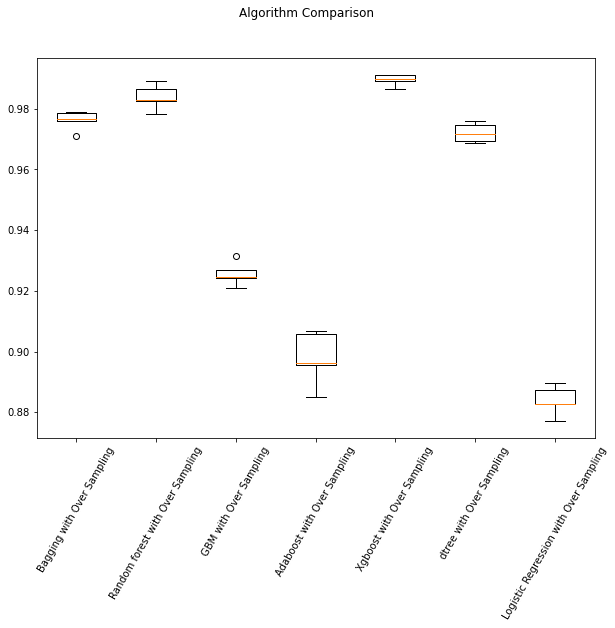

<IPython.core.display.Javascript object>

In [40]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names1)
plt.xticks(rotation=60)

plt.show()

After Over Sampling, the CrossValidation Score of almost all the models increased a lot; XGBoost being the top followed by Random Forest.

### Model Building with Undersampled data

In [41]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



<IPython.core.display.Javascript object>

In [42]:
models2 = []  # Empty list to store all the models created with under sampling

# Appending models into the list
models2.append(("Bagging with Under Sampling", BaggingClassifier(random_state=1)))
models2.append(
    ("Random forest with Under Sampling", RandomForestClassifier(random_state=1))
)
models2.append(("GBM with Under Sampling", GradientBoostingClassifier(random_state=1)))
models2.append(("Adaboost with Under Sampling", AdaBoostClassifier(random_state=1)))
models2.append(
    (
        "Xgboost with Under Sampling",
        XGBClassifier(random_state=1, eval_metric="logloss"),
    )
)
models2.append(("dtree with Under Sampling", DecisionTreeClassifier(random_state=1)))
models2.append(
    ("Logistic Regression with Under Sampling", LogisticRegression(random_state=1))
)

results2 = []  # Empty list to store all model's CV scores
names2 = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models2:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result2 = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results2.append(cv_result2)
    names2.append(name)
    print("{}: {}".format(name, cv_result2.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models2:
    model.fit(X_train_un, y_train_un)
    scores2 = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores2))


Cross-Validation Cost:

Bagging with Under Sampling: 0.8641945025611427
Random forest with Under Sampling: 0.9038669648654498
GBM with Under Sampling: 0.8990621167303946
Adaboost with Under Sampling: 0.8666113556020489
Xgboost with Under Sampling: 0.9074742082100858
dtree with Under Sampling: 0.8617776495202367
Logistic Regression with Under Sampling: 0.8726138085275232

Validation Performance:

Bagging with Under Sampling: 0.8705035971223022
Random forest with Under Sampling: 0.8920863309352518
GBM with Under Sampling: 0.8884892086330936
Adaboost with Under Sampling: 0.8489208633093526
Xgboost with Under Sampling: 0.9028776978417267
dtree with Under Sampling: 0.841726618705036
Logistic Regression with Under Sampling: 0.8525179856115108


<IPython.core.display.Javascript object>

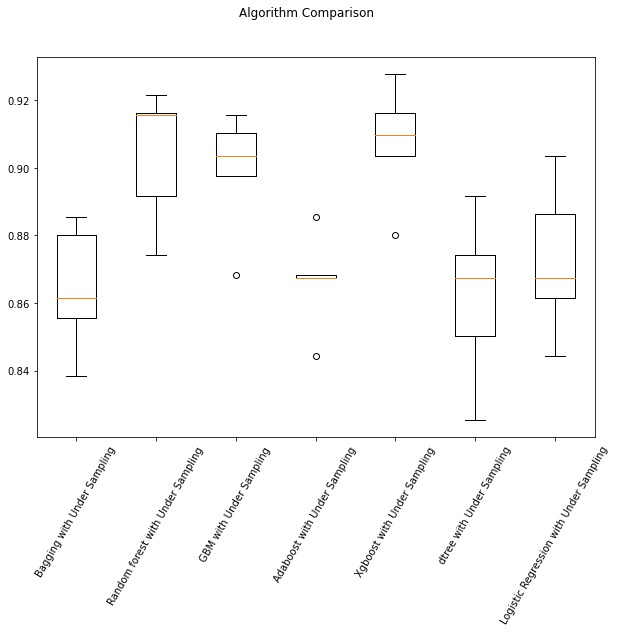

<IPython.core.display.Javascript object>

In [43]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.xticks(rotation=60)

plt.show()

With Under Sampling; the average Recall score is the highest for XGBoost being the top followed by Random Forest.

Comparing the Average Cross Validation Recall scores across all the models and the Validation dataset performance - these are the models that perform the best
* XGBoost Over Sampling
* Gradient Boosting Over Sampling
* AdaBoost OVer Sampling
* XGBoost Under sampling
* RandomForest Under sampling

## HyperparameterTuning 

### Hyperparameter tuning for RandomForest with Undersampled data

In [44]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:
CPU times: user 1.54 s, sys: 200 ms, total: 1.74 s
Wall time: 15.3 s


<IPython.core.display.Javascript object>

In [45]:
# Creating new pipeline with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=300, min_samples_leaf=2, max_features="sqrt", max_samples=0.5
)

rf_tuned.fit(X_train_un, y_train_un)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, min_samples_leaf=2,
                       n_estimators=300)

<IPython.core.display.Javascript object>

In [46]:
rftuned_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train_un, y_train_un
)
print("Train Performance:")
rftuned_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.962,0.931,0.991,0.960


<IPython.core.display.Javascript object>

In [47]:
rftuned_val_perf = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation Performance:")
rftuned_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.470,0.614


<IPython.core.display.Javascript object>

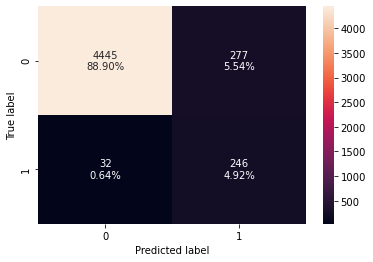

<IPython.core.display.Javascript object>

In [48]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned, X_val, y_val)

This hyper parameter tuned Random Forest with Under sampled data, did perform well on train and validation data. It is able to generalize well. Will try this with Grid Search CV and see if the performance can be made better.

### Hyperparamter Tuning for Random Forest with Under sampling- Grid Search

In [49]:
%%time 

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
params = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=params, n_jobs = -1, scoring=scorer, cv=5)

#Fitting parameters in RandomizedSearchCV
grid_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Best parameters are {'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 250} with CV score=0.8990188298102592:
CPU times: user 1.22 s, sys: 42.6 ms, total: 1.27 s
Wall time: 14.1 s


<IPython.core.display.Javascript object>

In [50]:
# Creating new pipeline with best parameters
rf_tuned_grid = RandomForestClassifier(
    n_estimators=250, min_samples_leaf=1, max_features="sqrt", max_samples=0.5
)

rf_tuned_grid.fit(X_train_un, y_train_un)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, n_estimators=250)

<IPython.core.display.Javascript object>

In [51]:
rftuned_grid_train_perf = model_performance_classification_sklearn(
    rf_tuned_grid, X_train_un, y_train_un
)
print("Train Performance:")
rftuned_grid_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.977,0.956,0.997,0.976


<IPython.core.display.Javascript object>

In [52]:
rftuned_grid_val_perf = model_performance_classification_sklearn(
    rf_tuned_grid, X_val, y_val
)
print("Validation Performance:")
rftuned_grid_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.939,0.885,0.474,0.617


<IPython.core.display.Javascript object>

The Grid Search CV on hyper parameter tuning for Random Forest with Under sampled data, did perform well on train and validation data. It is able to generalize well. COmpared to Randomized Search, Grid Search gave a little better performance (very minimal however).

### Hyperparameter tuning XGBoost with undersampled data

In [53]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 
            'gamma':[0,3,5], 
            'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 3} with CV score=0.9266575283168603:
CPU times: user 4.73 s, sys: 57.9 ms, total: 4.79 s
Wall time: 42 s


<IPython.core.display.Javascript object>

In [54]:
# Creating new pipeline with best parameters
xgb_tuned1 = XGBClassifier(
    n_estimators=250, scale_pos_weight=10, learning_rate=0.2, gamma=3, subsample=0.8
)

xgb_tuned1.fit(X_train_un, y_train_un)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [55]:
xgbtuned1_train_perf = model_performance_classification_sklearn(
    xgb_tuned1, X_train_un, y_train_un
)
print("Train Performance:")
xgbtuned1_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.996,0.998


<IPython.core.display.Javascript object>

In [56]:
xgbtuned1_val_perf = model_performance_classification_sklearn(xgb_tuned1, X_val, y_val)
print("Validation Performance:")
xgbtuned1_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.884,0.910,0.314,0.467


<IPython.core.display.Javascript object>

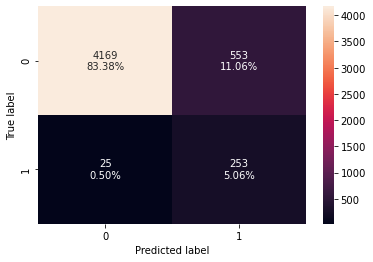

<IPython.core.display.Javascript object>

In [57]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_val, y_val)

Hyper parameter tuned XGB model with under sampled data, looks to be overfitting. It gave a Recall of 1 on Train data and 0.91 on validation data. We will build other models and then compare the performances.

### Hyperparamter tuning for XGBoost with oversampled data

In [58]:
%%time 

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],
            'scale_pos_weight':[5,10], 
            'learning_rate':[0.1,0.2], 
            'gamma':[0,3,5], 
            'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.995765154155294:
CPU times: user 1min, sys: 288 ms, total: 1min
Wall time: 13min 26s


<IPython.core.display.Javascript object>

In [59]:
# Creating new pipeline with best parameters
xgb_tuned2 = XGBClassifier(
    n_estimators=250, scale_pos_weight=10, learning_rate=0.2, gamma=0, subsample=0.8
)

xgb_tuned2.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [60]:
xgbtuned2_train_perf = model_performance_classification_sklearn(
    xgb_tuned2, X_train_over, y_train_over
)
print("Train Performance:")
xgbtuned2_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


<IPython.core.display.Javascript object>

In [61]:
xgbtuned2_val_perf = model_performance_classification_sklearn(xgb_tuned2, X_val, y_val)
print("Validation Performance:")
xgbtuned2_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.985,0.885,0.851,0.868


<IPython.core.display.Javascript object>

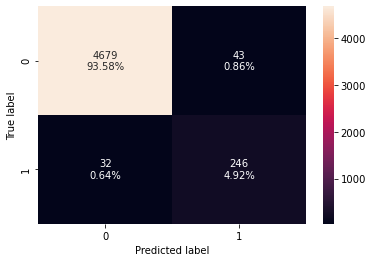

<IPython.core.display.Javascript object>

In [62]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned2, X_val, y_val)

Hyper parameter tuned XGB model with over sampled data, also looks to be overfitting. It gave a Recall of 1 on Train data and 0.885 on validation data. We will build other models and then compare the performances.

### Hyperparameter tuning for Gradient Boosting with Over sampling data

In [63]:
%%time 

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':np.arange(100,150,25),
            'max_features':[0.5,0.7], 
            'learning_rate':[0.2,0.05,1],     
            'subsample':[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9726851919894598:
CPU times: user 12.6 s, sys: 80.6 ms, total: 12.7 s
Wall time: 2min 46s


<IPython.core.display.Javascript object>

In [64]:
# Creating new pipeline with best parameters
gbm_tuned = GradientBoostingClassifier(
    n_estimators=125, max_features=0.5, learning_rate=1, subsample=0.7
)

gbm_tuned.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           subsample=0.7)

<IPython.core.display.Javascript object>

In [65]:
gbmtuned_train_perf = model_performance_classification_sklearn(
    gbm_tuned, X_train_over, y_train_over
)
print("Train Performance:")
gbmtuned_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.994,0.993,0.994,0.994


<IPython.core.display.Javascript object>

In [66]:
gbmtuned_val_perf = model_performance_classification_sklearn(gbm_tuned, X_val, y_val)
print("Validation Performance:")
gbmtuned_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.968,0.842,0.665,0.743


<IPython.core.display.Javascript object>

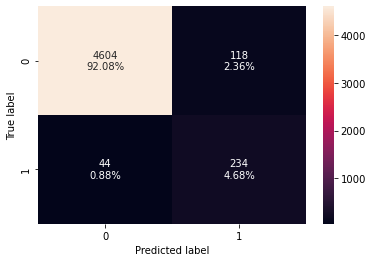

<IPython.core.display.Javascript object>

In [67]:
# creating confusion matrix
confusion_matrix_sklearn(gbm_tuned, X_val, y_val)

Hyperparameter tuned Gradient Boosting Algorithm with over sampling performed very well on Train data. Recall score is 0.993 for train data. It performed well with Validation data as well with Recall score of 0.842. We will compare with other models and see if this could be the best.

### Hyperparameter Tuning of AdaBoosting with Over Sampled data

In [68]:
%%time 

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9715559462639259:
CPU times: user 1min 2s, sys: 55.2 ms, total: 1min 2s
Wall time: 4min 51s


<IPython.core.display.Javascript object>

In [69]:
# Creating new pipeline with best parameters
ada_tuned = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    base_estimator=DecisionTreeClassifier(max_depth=3),
)

ada_tuned.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.2, n_estimators=200)

<IPython.core.display.Javascript object>

In [70]:
adatuned_train_perf = model_performance_classification_sklearn(
    ada_tuned, X_train_over, y_train_over
)
print("Train Performance:")
adatuned_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


<IPython.core.display.Javascript object>

In [71]:
adatuned_val_perf = model_performance_classification_sklearn(ada_tuned, X_val, y_val)
print("Validation Performance:")
adatuned_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


<IPython.core.display.Javascript object>

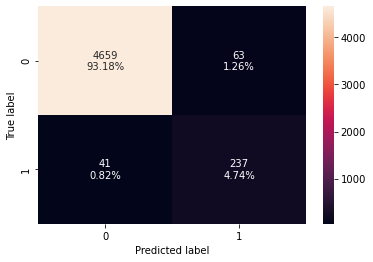

<IPython.core.display.Javascript object>

In [72]:
# creating confusion matrix
confusion_matrix_sklearn(ada_tuned, X_val, y_val)

Ada Boosting algorithm with over sampled data is hyper tuned and it performed well on Train dataset; and good on Validation dataset. We will try with GridSearch CV and see if the performance could be improved. 

### Hyper Parameter Tunning on AdaBoost ALgorithm with oversampled data - Grid Search CV

In [73]:
%%time 

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
params = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
grid_cv = GridSearchCV(estimator=Model, param_grid=params, n_jobs = -1, scoring=scorer, cv=5)

#Fitting parameters in RandomizedSearchCV
grid_cv.fit(X_train_over,y_train_over) 

print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Best parameters are {'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1), 'learning_rate': 0.2, 'n_estimators': 200} with CV score=0.9715559462639259:
CPU times: user 1min 1s, sys: 46.4 ms, total: 1min 1s
Wall time: 4min 52s


<IPython.core.display.Javascript object>

In [74]:
# Creating new pipeline with best parameters
ada_tuned_grid = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    base_estimator=DecisionTreeClassifier(max_depth=3),
)

ada_tuned_grid.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.2, n_estimators=200)

<IPython.core.display.Javascript object>

In [75]:
adatuned_grid_train_perf = model_performance_classification_sklearn(
    ada_tuned_grid, X_train_over, y_train_over
)
print("Train Performance:")
adatuned_grid_train_perf

Train Performance:


,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


<IPython.core.display.Javascript object>

In [76]:
adatuned_grid_val_perf = model_performance_classification_sklearn(
    ada_tuned_grid, X_val, y_val
)
print("Validation Performance:")
adatuned_grid_val_perf

Validation Performance:


,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


<IPython.core.display.Javascript object>

Hyper parameter tuning with Grid Search CV on Ada Boosting algorithm with Udner Sampled data gave same Recall score on Train data and almost similar Recall score on Validation data. 

## Model performance comparison and choosing the final model

In [77]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        gbmtuned_train_perf.T,
        adatuned_train_perf.T,
        adatuned_grid_train_perf.T,
        rftuned_train_perf.T,
        rftuned_grid_train_perf.T,
        xgbtuned2_train_perf.T,
        xgbtuned1_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data-GridSearch CV",
    "Random forest tuned with undersampled data",
    "Random forest tuned with undersampled data-GridSearchCV",
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,AdaBoost classifier tuned with oversampled data-GridSearch CV,Random forest tuned with undersampled data,Random forest tuned with undersampled data-GridSearchCV,XGBoost tuned with oversampled data,XGBoost tuned with undersampled data
Accuracy,0.994,0.992,0.992,0.962,0.977,1.000,0.998
Recall,0.993,0.988,0.988,0.931,0.956,1.000,1.000
Precision,0.994,0.995,0.995,0.991,0.997,1.000,0.996
F1,0.994,0.992,0.992,0.960,0.976,1.000,0.998


<IPython.core.display.Javascript object>

In [78]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        gbmtuned_val_perf.T,
        adatuned_val_perf.T,
        adatuned_grid_val_perf.T,
        rftuned_val_perf.T,
        rftuned_grid_val_perf.T,
        xgbtuned2_val_perf.T,
        xgbtuned1_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data-GridSearchCV",
    "Random forest tuned with undersampled data",
    "Random forest tuned with undersampled data-GridSearchCV",
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,AdaBoost classifier tuned with oversampled data-GridSearchCV,Random forest tuned with undersampled data,Random forest tuned with undersampled data-GridSearchCV,XGBoost tuned with oversampled data,XGBoost tuned with undersampled data
Accuracy,0.968,0.979,0.979,0.938,0.939,0.985,0.884
Recall,0.842,0.853,0.853,0.885,0.885,0.885,0.910
Precision,0.665,0.790,0.790,0.470,0.474,0.851,0.314
F1,0.743,0.820,0.820,0.614,0.617,0.868,0.467


<IPython.core.display.Javascript object>

Random Forest tuned with Undersampled data (with Grid Search CV) turns out to be able to generalize the data well. The Recall score on Train data is 0.956 and validation data is 0.885.

AdaBoost algorithm tuned with oversampled data (withh Grid Serach CV) also looks to be performing well. But the score between Train and Validation is little on higher side compared to Random Forest. 

Other models are overfitting. The Recall score varies too much from Train vs Validation data.

So I am picking the tuned Random Forest with Undersampled data, with GridSearchCV as my final best model. 

### Test set final performance

In [79]:
# Calculating different metrics on the test set
rftuned_grid_test = model_performance_classification_sklearn(
    rf_tuned_grid, X_test, y_test
)
print("Test performance:")
rftuned_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.944,0.879,0.503,0.640


<IPython.core.display.Javascript object>

Tuned Random forest with undersampled data is the best performing model from all the modesl that were built. It has got a Recall score of 0.885 on Validation and 0.879 on Test datasets. So this model is able to generalize the data well.

In [80]:
print(
    pd.DataFrame(
        rf_tuned_grid.feature_importances_, columns=["Imp"], index=X_train_un.columns
    ).sort_values(by="Imp", ascending=False)
)

      Imp
V36 0.099
V18 0.095
V39 0.066
V3  0.049
V15 0.041
V16 0.041
V21 0.039
V7  0.036
V11 0.033
V14 0.030
V26 0.030
V13 0.028
V28 0.027
V12 0.026
V34 0.021
V35 0.020
V9  0.020
V37 0.018
V4  0.015
V24 0.014
V10 0.014
V19 0.014
V31 0.014
V1  0.014
V30 0.014
V5  0.014
V40 0.013
V8  0.013
V38 0.013
V20 0.013
V25 0.013
V6  0.013
V22 0.012
V2  0.012
V33 0.012
V23 0.012
V17 0.011
V29 0.011
V32 0.010
V27 0.010


<IPython.core.display.Javascript object>

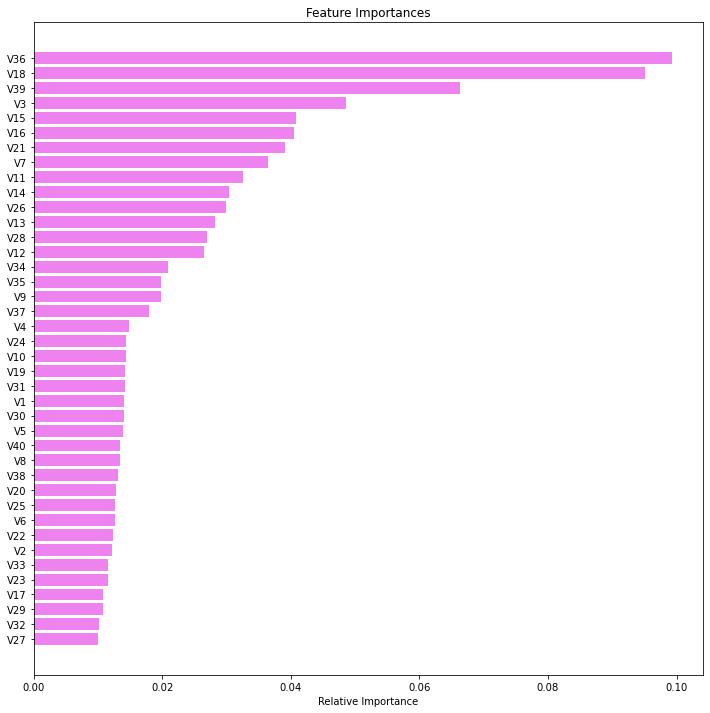

<IPython.core.display.Javascript object>

In [81]:
feature_names = X.columns
importances = rf_tuned_grid.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

From the feature importances, V36 is the most important feature in predicting the Target variable.
It is followed by V18, V39, V3 and V15.

## Pipelines to build the final model


Random forest tuned with hyperameters on undersampled data turned out to be the best performing model when verified against Validation and test data sets. So we will use this to create our Pipeline.

In [82]:
# Splitting the train data to Target and other variables
X1 = data.drop(columns="Target")
y1 = data["Target"]

# Splitting the test data to Target and other variables
X1_test = data_test.drop(columns="Target")
y1_test = data_test["Target"]

<IPython.core.display.Javascript object>

In [83]:
print(X1.shape, X1_test.shape)

(20000, 40) (5000, 40)


<IPython.core.display.Javascript object>

In [84]:
imputer = SimpleImputer(strategy="median")

<IPython.core.display.Javascript object>

In [85]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X1_undrsamp, y1_undrsamp = rus.fit_resample(X1, y1)

<IPython.core.display.Javascript object>

Best parameters are {'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 250}

In [86]:
# Creating new pipeline with best parameters
final_model = Pipeline(
    steps=[
        ("imputer", imputer),
        (
            "estimator",
            RandomForestClassifier(
                n_estimators=250,
                min_samples_leaf=1,
                max_features="sqrt",
                max_samples=0.5,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [87]:
# Fit the model on undersampled training data
final_model.fit(X1_undrsamp, y1_undrsamp)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('estimator',
                 RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                                        n_estimators=250))])

<IPython.core.display.Javascript object>

In [88]:
# Let's check the performance on test set
Model_train1 = model_performance_classification_sklearn(
    final_model, X1_undrsamp, y1_undrsamp
)
Model_train1

,Accuracy,Recall,Precision,F1
0,0.969,0.941,0.998,0.968


<IPython.core.display.Javascript object>

In [89]:
# Let's check the performance on test set
Model_test1 = model_performance_classification_sklearn(final_model, X1_test, y1_test)
Model_test1

,Accuracy,Recall,Precision,F1
0,0.947,0.869,0.516,0.647


<IPython.core.display.Javascript object>

The Recall score is 0.941 on Train dataset and 0.869 on Test dataset; so model is able to generalize well.

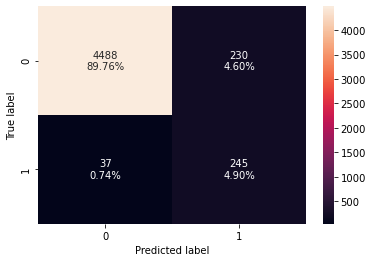

<IPython.core.display.Javascript object>

In [90]:
# creating confusion matrix
confusion_matrix_sklearn(final_model, X1_test, y1_test)

**Confusion Matrix -**

* 4.90% True Positive (observed=1,predicted=1), model predicted failures and actually its a failure. -- Repair costs

* 4.60% False Positive (observed=0,predicted=1), model predicted failures but actually its not a failure. -- Inspection Costs

* 89.76% True Negative (observed=0,predicted=0), model predicted no failures and actually also its not a failure.

* 0.74% False Negative (observed=1,predicted=0), model predicted no failures but actually its a failure. -- Replacement costs

# Business Insights and Conclusions

***Random Forest with Undersampled data and tuned with hyperparameters is identified as the best model.
The model is able to perform well on the Test data and able to generalize too.***

We are interested to reduce the False Negatives and so maximizing the Recall score is important. 
On unseen data, this model was able to produce a Recall score of 0.869 and able to generalize well. 

The important features turned out to be V36, V18 and V39. Since the data is ciphered not able to exactly point out which features these are; but Renewind should be able to predict the generator failures based on these. These features should be given utmost importance to be able to predict the failures of the generators in advance and so could repair or inspect them. From the Heatmap, V36, V18 and V39 showed a negative Correlation which means if these values increase, the Target would decrease. So the lesser the values in these features, there would be chance of failures. 

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

Our goal was to reduce False Negatives since they are actually failures but model could not predict them. This would result in replacement costs of the generators which would be expensive for ReneWind. Our model did good and able to reduce False Negatives, with False negative rate of only 0.72%.